In [38]:
import numpy as np
import os, glob
import matplotlib.pyplot as plt
import scipy
import mplhep as hep
import scipy.optimize as optimize
from scipy.stats import norm
from scipy.special import erf

plt.style.use([hep.style.ROOT, hep.style.firamath])
import pickle, glob
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
channel_list = ["Tracks_pt", "Tracks_dZSig", "Tracks_d0Sig", "ECAL_energy",
"HBHE_energy", "Pix_1", "Pix_2", "Pix_3", "Pix_4", "Tib_1", "Tib_2",
"Tib_3", "Tib_4", "Tob_1", "Tob_2", "Tob_3", "Tob_4", "Tob_5",
"Tob_6", "Tid_1", "Tec_1", "Tec_2", "Tec_3"]

from scipy.stats import norm
# Define the CMS color scheme
cms_colors = [
    (0.00, '#FFFFFF'),  # White
    (0.33, '#005EB8'),  # Blue
    (0.66, '#FFDD00'),  # Yellow
    (1.00, '#FF0000')   # red
]

# Create the CMS colormap
cms_cmap = LinearSegmentedColormap.from_list('CMS', cms_colors)

# out_dir='plots'
# if not os.path.isdir(out_dir):
#     os.makedirs(out_dir)
# save = True

In [39]:
parent_folder_path = '/global/cfs/cdirs/m4392/bbbam/mass_regression_models_for_validation_tests_using_data_v2/mass_trainer_aToTauTau_m1p2To17p2_v2_13ch/INFERENCE_DATA'

# Function for fitting signals

In [223]:

##---------------------------------------------------------------------------------
class AsymmetricGaussian:
    def __init__(self, mu, sigmaL, sigmaR, lambda_):
        self.mu = mu
        self.sigmaL = sigmaL
        self.sigmaR = sigmaR
        self.lambda_ = lambda_
    
    def __call__(self, x):
        z = (x - self.mu) / (self.sigmaL + self.sigmaR)
        pdf_value = (1 / (self.sigmaL + self.sigmaR)) * (
            norm.pdf(z) * norm.cdf(self.lambda_ * z)
        )
        return pdf_value
    
def nLLH_AG(params, data):
    mu, sigmaL, sigmaR, lambda_ = params
    pdf = AsymmetricGaussian(mu, sigmaL, sigmaR, lambda_)
    pdf_values = pdf(data)
    pdf_values = np.maximum(pdf_values, 1e-100)  # Avoid log(0)
    return -np.sum(np.log(pdf_values))

def nLLH_AG_calculation(m_pred_):
    initial_guess = [10, 1.0, 1.0, 1.0]
    # Minimize the negative log-likelihood
    result=optimize.minimize(lambda params: nLLH_AG(params, m_pred_),initial_guess, method='L-BFGS-B')
    # Extract the fitted parameters
    fitted_params = result.x
    fitted_pdf = AsymmetricGaussian(*fitted_params)
    print('FITTED PARAMETER', fitted_params)
    return fitted_pdf

##---------------------------------------------------------------------------------
class GaussianModified:
    def __init__(self, k, x0, sig, a):
        self.k = k      # Amplitude factor
        self.x0 = x0    # Mean of the Gaussian
        self.sig = sig  # Standard deviation of the Gaussian
        self.a = a      # Parameter for the error function

    def __call__(self, x):
        # Compute the Gaussian term
        gaussian_term = np.exp(-((x - self.x0) ** 2) / (2 * self.sig ** 2))
        # Compute the error function term
        erf_term = 1 + erf((self.a * (x - self.x0)) / (self.sig * np.sqrt(2)))
        # Combine them
        return self.k * gaussian_term * erf_term
    
def nLLH_GM(params, data):
    k, x0, sig, a = params
    pdf = GaussianModified(k, x0, sig, a)
    pdf_values = pdf(data)
    pdf_values = np.maximum(pdf_values, 1e-100)  # Avoid log(0)
    return -np.sum(np.log(pdf_values))

def nLLH_GM_calculation(m_pred_):
    initial_guess = [mass, 1.0, 1.0, 1.0]
    # Minimize the negative log-likelihood
    result=optimize.minimize(lambda params: nLLH_GM(params, m_pred_),initial_guess, method='L-BFGS-B')
    # Extract the fitted parameters
    fitted_params = result.x
    print('FITTED PARAMETER', fitted_params)
    fitted_pdf = GaussianModified(*fitted_params)
    return fitted_pdf
##---------------------------------------------------------------------------------
class gaussian_peak:
    def __init__(self, a, m0, sig):
        self.a = a  # amplitude of the Gaussian
        self.m0 = m0  # mean of gaussian
        self.sig = sig  # Standard deviation of the Gaussian
    def __call__(self, x):
         return self.a * np.exp(-((x - self.m0)**2) / (2 * self.sig**2))

        
def nLLH_GP(params, data):
    a, m0, sig = params
    pdf = gaussian_peak(a, m0, sig)
    pdf_values = pdf(data)
    pdf_values = np.maximum(pdf_values, 1e-100)  # Avoid log(0)
    return -np.sum(np.log(pdf_values))
def nLLH_GP_calculation(m_pred_):
    initial_guess = [10, 10, 10]
    # Minimize the negative log-likelihood
    result=optimize.minimize(lambda params: nLLH_GP(params, m_pred_),initial_guess, method='L-BFGS-B')
    # Extract the fitted parameters
    fitted_params = result.x
    fitted_pdf = gaussian_peak(*fitted_params)
    print('FITTED PARAMETER', fitted_params)
    return fitted_pdf
##---------------------------------------------------------------------------------



class CruijffPdf:
    def __init__(self, m0, sigmaL, sigmaR, alphaL, alphaR, amplitude):
        self.m0 = m0
        self.sigmaL = sigmaL
        self.sigmaR = sigmaR
        self.alphaL = alphaL
        self.alphaR = alphaR
        self.amplitude = amplitude
    
    def __call__(self, m):
        dx = m - self.m0
        sigma = np.where(dx < 0, self.sigmaL, self.sigmaR)
        alpha = np.where(dx < 0, self.alphaL, self.alphaR)
        f = 2 * sigma**2 + alpha * dx**2
        return self.amplitude*np.exp(-dx**2/f) 

def nLLH_CF(params, data):
    m0, sigmaL, sigmaR, alphaL, alphaR, amp = params
    pdf = CruijffPdf(m0, sigmaL, sigmaR, alphaL, alphaR, amp)
    pdf_values = pdf(data)
    pdf_values = np.maximum(pdf_values, 1e-100)  # Avoid log(0)
    return -np.sum(np.log(pdf_values))

def nLLH_CF_calculation(m_pred_):
    initial_guess = [10, 1.0, 1.0, 1.5, 1.5,0.5]
    # Minimize the negative log-likelihood
    result=optimize.minimize(lambda params: nLLH_CF(params, m_pred_),initial_guess, method='L-BFGS-B')
    fitted_params = result.x
    print('FITTED PARAMETER', fitted_params)
    fitted_pdf = CruijffPdf(*fitted_params)
    return fitted_pdf
##---------------------------------------------------------------------------------

class GaussianPdf:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    
    def __call__(self, x):
        return (1 / (self.sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - self.mu) / self.sigma)**2)

def nLLH_G(params, data):
    mu, sigma = params
    pdf = GaussianPdf(mu, sigma)
    pdf_values = pdf(data)
    pdf_values = np.maximum(pdf_values, 1e-100)  # Avoid log(0)
    return -np.sum(np.log(pdf_values))

def nLLH_G_calculation(m_pred_):
    initial_guess = [10, 1.0]
    # Minimize the negative log-likelihood
    result=optimize.minimize(lambda params: nLLH_G(params, m_pred_),initial_guess, method='L-BFGS-B')
    # Extract the fitted parameters
    fitted_params = result.x
    print('FITTED PARAMETER', fitted_params)
    fitted_pdf = GaussianPdf(*fitted_params)
    return fitted_pdf

###----------------------------------------------------------------------------------------------------------------------------------------------------


class BreitWignerPdf:
    def __init__(self, E0, Gamma):
        self.E0 = E0  # Resonance energy
        self.Gamma = Gamma  # Width of the resonance
    
    def __call__(self, E):
        # Relativistic Breit-Wigner formula
        numerator = self.E0 * self.Gamma
        denominator = (E**2 - self.E0**2)**2 + (self.E0 * self.Gamma)**2
        return numerator / denominator

def nLLH_BW(params, data):
    E0, Gamma = params
    pdf = BreitWignerPdf(E0, Gamma)
    pdf_values = pdf(data)
    pdf_values = np.maximum(pdf_values, 1e-100)  # Avoid log(0)
    return -np.sum(np.log(pdf_values))

def nLLH_BW_calculation(m_pred_):
    initial_guess = [10, 1.0]  # Initial guess for E0 and Gamma
    # Minimize the negative log-likelihood
    result = optimize.minimize(lambda params: nLLH_BW(params, m_pred_), initial_guess, method='L-BFGS-B')
    # Extract the fitted parameters
    fitted_params = result.x
    print('FITTED PARAMETERS:', fitted_params)
    fitted_pdf = BreitWignerPdf(*fitted_params)
    return fitted_pdf
###-------------------------------------------------------------------------------------------------------------------------------------------------------


class CrystalBallPdf:
    def __init__(self, alpha, n, mean, sigma):
        self.alpha = alpha
        self.n = n
        self.mean = mean
        self.sigma = sigma
        
        self.A = (n / abs(alpha))**n * np.exp(-0.5 * alpha**2)
        self.B = n / abs(alpha) - abs(alpha)
        self.C = n / abs(alpha) * (1 / (n - 1)) * np.exp(-0.5 * alpha**2)
        self.D = np.sqrt(np.pi / 2) * (1 + scipy.special.erf(abs(alpha) / np.sqrt(2)))

    def __call__(self, x):
        t = (x - self.mean) / self.sigma
        if t > -self.alpha:
            return np.exp(-0.5 * t**2)
        else:
            return self.A * (self.B - t)**(-self.n)

def nLLH_CB(params, data):
    alpha, n, mean, sigma = params
    pdf = CrystalBallPdf(alpha, n, mean, sigma)
    pdf_values = np.array([pdf(x) for x in data])
    pdf_values = np.maximum(pdf_values, 1e-100)  # Avoid log(0)
    return -np.sum(np.log(pdf_values))

def nLLH_CB_calculation(m_pred_):
    initial_guess = [1.0, 2.0, np.mean(m_pred_), np.std(m_pred_)]  # Initial guess for alpha, n, mean, sigma
    # Minimize the negative log-likelihood
    result = optimize.minimize(lambda params: nLLH_CB(params, m_pred_), initial_guess, method='L-BFGS-B')
    # Extract the fitted parameters
    fitted_params = result.x
    print('FITTED PARAMETERS:', fitted_params)
    fitted_pdf = CrystalBallPdf(*fitted_params)
    return fitted_pdf



## Check the shape of functions

In [226]:
x = np.linspace(0,20,1000)
# x= m_pred_
##--------------------Gaussian---------------------------------

# fitted_params = [2, 0.1]
# fitted_pdf = GaussianPdf(*fitted_params)

##---------------------Cruijff--------------------------------

# fitted_params = [5, 0.6, 0.8, 1, 1, 1]
# fitted_pdf =  CruijffPdf(*fitted_params)

##--------------------AsymmetricGaussian---------------------------

# fitted_params = [10, 2.0, 2.0, -1]
# fitted_pdf = AsymmetricGaussian(*fitted_params)

##--------------------gaussian_peak---------------------------

# fitted_params = [10, 1.0, 1.0]
# fitted_pdf = fitted_pdf = gaussian_peak(*fitted_params)

##--------------------GaussianModified---------------------------
# fitted_params = [10, 10, 4.0, 3.0]
# fitted_pdf = fitted_pdf = GaussianModified(*fitted_params)

##--------------------BreitWignerPdf---------------------------

# fitted_params = [5.0, 2]
# fitted_pdf = fitted_pdf = BreitWignerPdf(*fitted_params)


##--------------------CrystalBallPdf---------------------------

fitted_params = [1, 2, 5, 2]
fitted_pdf = CrystalBallPdf(*fitted_params)


y = fitted_pdf(x)
plt.plot(x,y)
plt.axvline(x=fitted_params[0],linestyle="--", color='r')

# plt.hist(np.array(m_pred_).flatten(),range=(0,m0_max+1.2), bins=len(np.arange(0,m0_max+1.2,bin_size)), density=True, histtype='step',  linestyle='-', color='b', linewidth=2, label='E2E prediction')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

for mass:   4
FITTED PARAMETERS: [5.55793187 1.84067288]


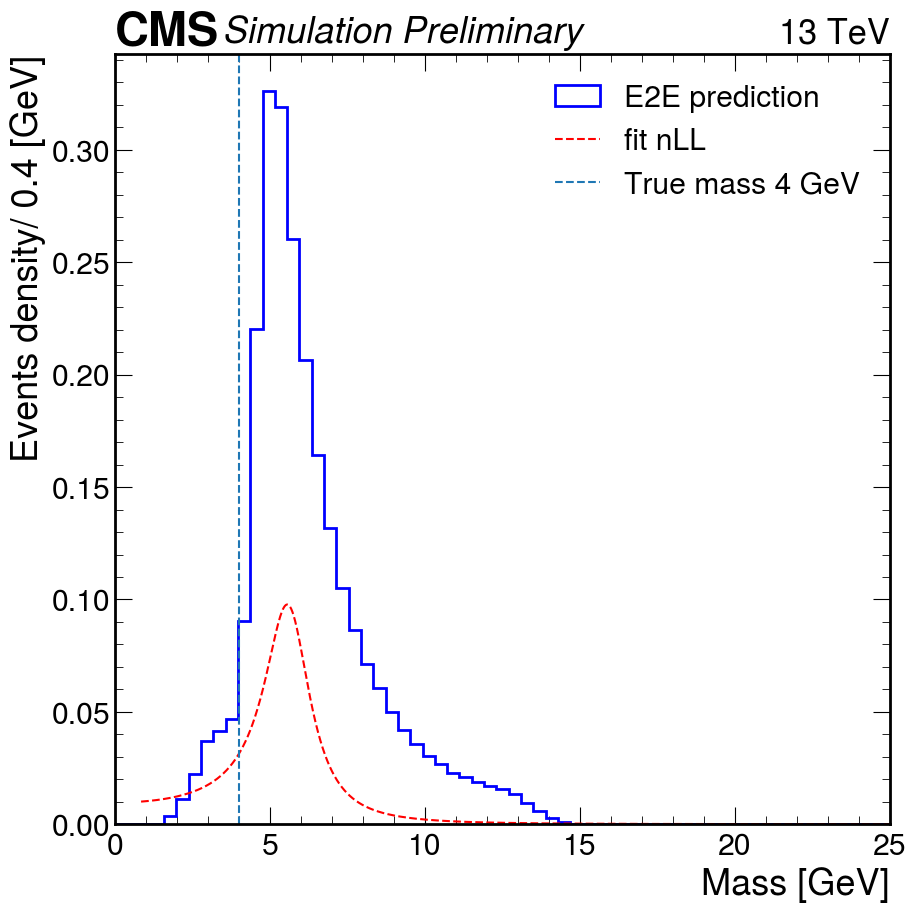

In [219]:
Mass = '4'
mass  = {'3p7':3.7,'4':4, '5':5, '6':6, '8':8, '10':10, '12':12, '14':14}.get(Mass, None)
print('for mass:  ', mass)
paths=np.sort(glob.glob(f'{parent_folder_path}/INFERENCE_13_channels_aToTauTau_m1p2To17p2_pT30To180_M_{Mass}_H_AA_4Tau/epoch10_val_pseudoscala*.pkl'))
assert len(paths) > 0


m0_min = 0
m0_max = 25
bin_size = 0.4

infile = open(f"{paths[0]}", "rb")
data = pickle.load(infile)
infile.close()
m_pred_ = data["m_pred"]


#------------below for fitting central bins only--------------------------------------------------------
    
def get_central_bins(data, lower_mass=1.2, upper_mass=17.2, bin_size=0.4, number_bins=6):
    bins=np.arange(lower_mass, upper_mass+bin_size, bin_size)
    counts, bin_edges = np.histogram(data, bins=bins)

    # Find the index of the mode bin
    mode_bin_index = np.argmax(counts)
    start_bin_index = min(0, abs(mode_bin_index-number_bins))
    end_bin_index = min(mode_bin_index+number_bins, len(bins)-1)
    central_bins = np.arange(bins[start_bin_index], bins[end_bin_index]+bin_size, bin_size)
    return central_bins 

central_bins = get_central_bins(m_pred_, lower_mass=1.2, upper_mass=17.2, bin_size=0.4, number_bins=5)
mask = (m_pred_ >= central_bins[0]) & (m_pred_ < central_bins[-1])

# m_pred_ = m_pred_[mask]

#------------above this for fitting central bins only---------------------------------------------------



x = np.linspace(min(m_pred_), max(m_pred_),10000)


fitted_pdf = nLLH_BW_calculation(m_pred_)
y = fitted_pdf(x)

# mu, std = norm.fit(m_pred_)
# print(mu, std)
# # mu, std = 5, 0.75
# y = norm.pdf(x, mu, std)


fig, ax = plt.subplots()
plt.hist(np.array(m_pred_).flatten(),range=(0,m0_max+1.2), bins=len(np.arange(0,m0_max+1.2,bin_size)), density=True, histtype='step',  linestyle='-', color='b', linewidth=2, label='E2E prediction')
# plt.show()
plt.plot(x, y,linestyle='--', color='red',label=f'fit nLL')
plt.axvline(x= mass,linestyle='--',label=f'True mass {Mass} GeV')
plt.xlim(0,25)
plt.xlabel('Mass [GeV]')
plt.ylabel('Events density/ 0.4 [GeV]')
plt.legend(loc='best')
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
plt.show() 


In [135]:
data=m_pred_ 
lower_mass=1.2
upper_mass=17.3
bin_size=0.4
def get_central_bins(data, lower_mass=1.2, upper_mass=17.2, bin_size=0.4, number_bins=6):
    bins=np.arange(lower_mass, upper_mass+bin_size, bin_size)
    counts, bin_edges = np.histogram(data, bins=bins)

    # Find the index of the mode bin
    mode_bin_index = np.argmax(counts)
    start_bin_index = min(0, abs(mode_bin_index-number_bins))
    end_bin_index = min(mode_bin_index+number_bins, len(bins)-1)
    central_bins = np.arange(bins[start_bin_index], bins[end_bin_index]+bin_size, bin_size)
    return central_bins 



# Find the index of the mode bin

print(get_central_bins(data, lower_mass=1.2, upper_mass=17.2, bin_size=0.4, number_bins=6))



[1.2 1.6 2.  2.4 2.8 3.2 3.6 4.  4.4 4.8 5.2 5.6 6.  6.4 6.8 7.2 7.6 8.
 8.4]


# --------------- Fitting  on signals ------------------

In [162]:
def fit_signal(Mass='4'):
    mass  = {'3p7':3.7,'4':4, '5':5, '6':6, '8':8, '10':10, '12':12, '14':14}.get(Mass, None)
    print('for mass:  ', mass)
    paths=np.sort(glob.glob(f'{parent_folder_path}/INFERENCE_13_channels_aToTauTau_m1p2To17p2_pT30To180_M_{Mass}_H_AA_4Tau/epoch10_val_pseudoscala*.pkl'))
    assert len(paths) > 0


    m0_min = 0
    m0_max = 25
    bin_size = 0.4

    infile = open(f"{paths[0]}", "rb")
    data = pickle.load(infile)
    infile.close()
    m_pred_ = data["m_pred"]
    
    #------------below for fitting central bins only--------------------------------------------------------
    
    def get_central_bins(data, lower_mass=1.2, upper_mass=17.2, bin_size=0.4, number_bins=6):
        bins=np.arange(lower_mass, upper_mass+bin_size, bin_size)
        counts, bin_edges = np.histogram(data, bins=bins)

        # Find the index of the mode bin
        mode_bin_index = np.argmax(counts)
        start_bin_index = min(0, abs(mode_bin_index-number_bins))
        end_bin_index = min(mode_bin_index+number_bins, len(bins)-1)
        central_bins = np.arange(bins[start_bin_index], bins[end_bin_index]+bin_size, bin_size)
        return central_bins 

    central_bins = get_central_bins(m_pred_, lower_mass=1.2, upper_mass=17.2, bin_size=0.4, number_bins=5)
    mask = (m_pred_ >= central_bins[0]) & (m_pred_ < central_bins[-1])

    m_pred_ = m_pred_[mask]
    
    #------------above this for fitting central bins only---------------------------------------------------

    
    x = np.linspace(min(m_pred_), max(m_pred_),10000)


    fitted_pdf = nLLH_GP_calculation(m_pred_)
    y = fitted_pdf(x)

    # mu, std = norm.fit(m_pred_)
    # y1 = norm.pdf(x, mu, std)


    fig, ax = plt.subplots()
    plt.hist(np.array(m_pred_).flatten(),range=(0,m0_max+1.2), bins=len(np.arange(0,m0_max+1.2,bin_size)), density=True, histtype='step',  linestyle='-', color='b', linewidth=2, label='E2E prediction')
    plt.plot(x, y,linestyle='--', color='red',label=f'fit nLL')
    plt.axvline(x= mass,linestyle='--',label=f'True mass {Mass} GeV')
    plt.xlim(0,25)
    plt.xlabel('Mass [GeV]')
    plt.ylabel('Events density/ 0.4 [GeV]')
    plt.legend(loc='best')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    plt.show() 

for mass:   3.7
FITTED PARAMETER [7615472.04903646 -295417.74975013  879699.95876026]


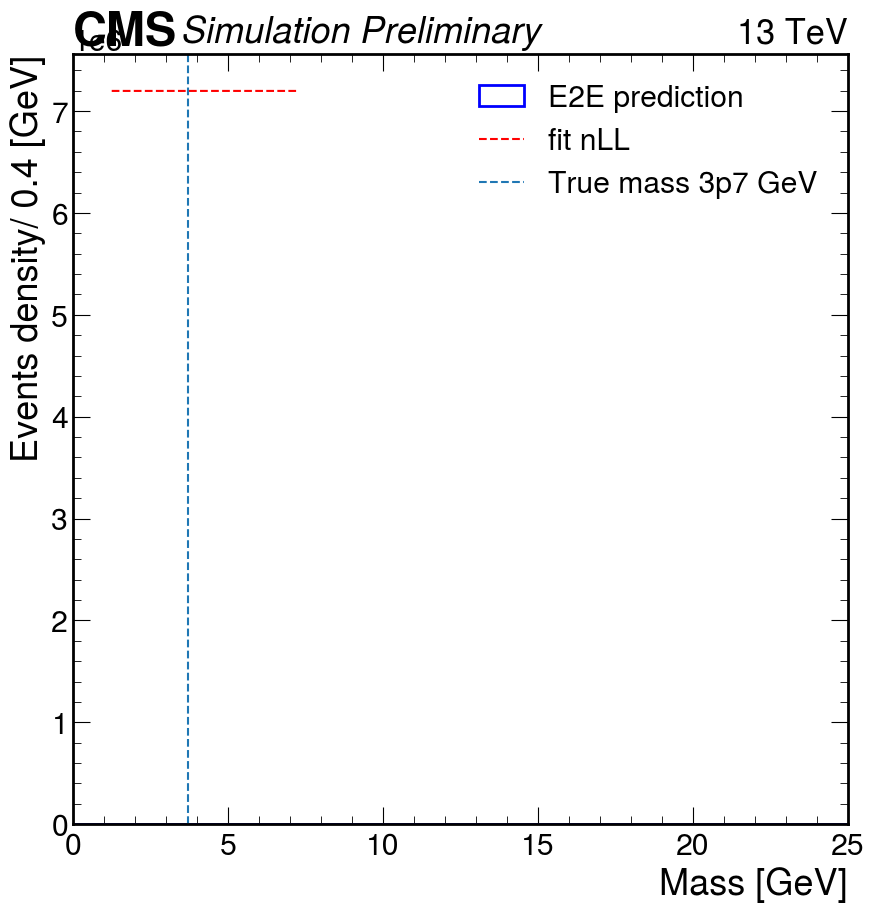

for mass:   4
FITTED PARAMETER [4931198.28727045  -15709.51112798   64145.0397313 ]


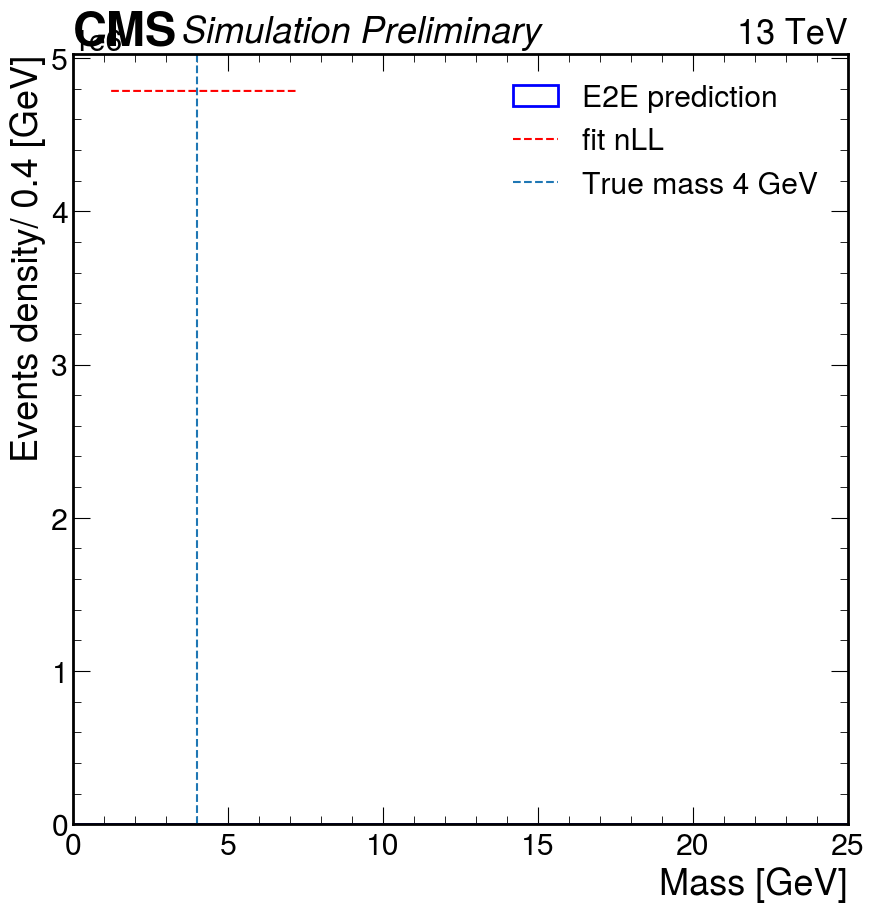

for mass:   5
FITTED PARAMETER [4004684.66050039  -20977.40847349 1006488.62683571]


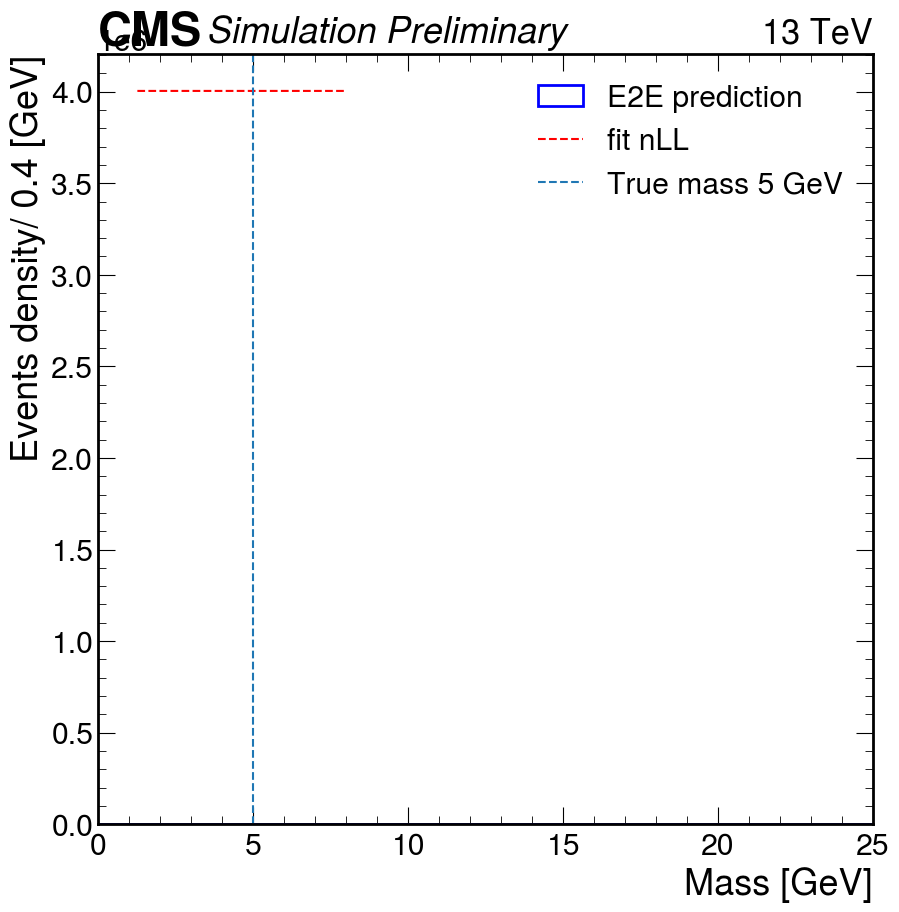

for mass:   6
FITTED PARAMETER [9.62924873e+06 8.33319779e+03 3.75536360e+05]


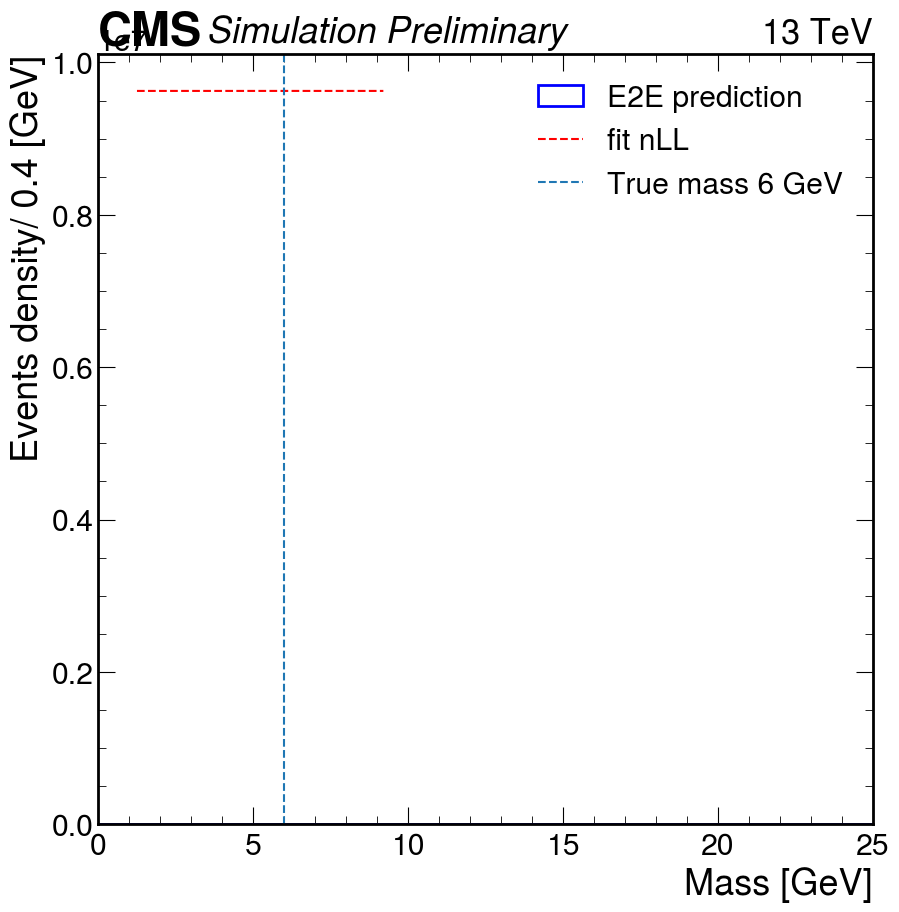

for mass:   8
FITTED PARAMETER [ 2.37713716e+11  2.46887979e+07 -5.05897507e+08]


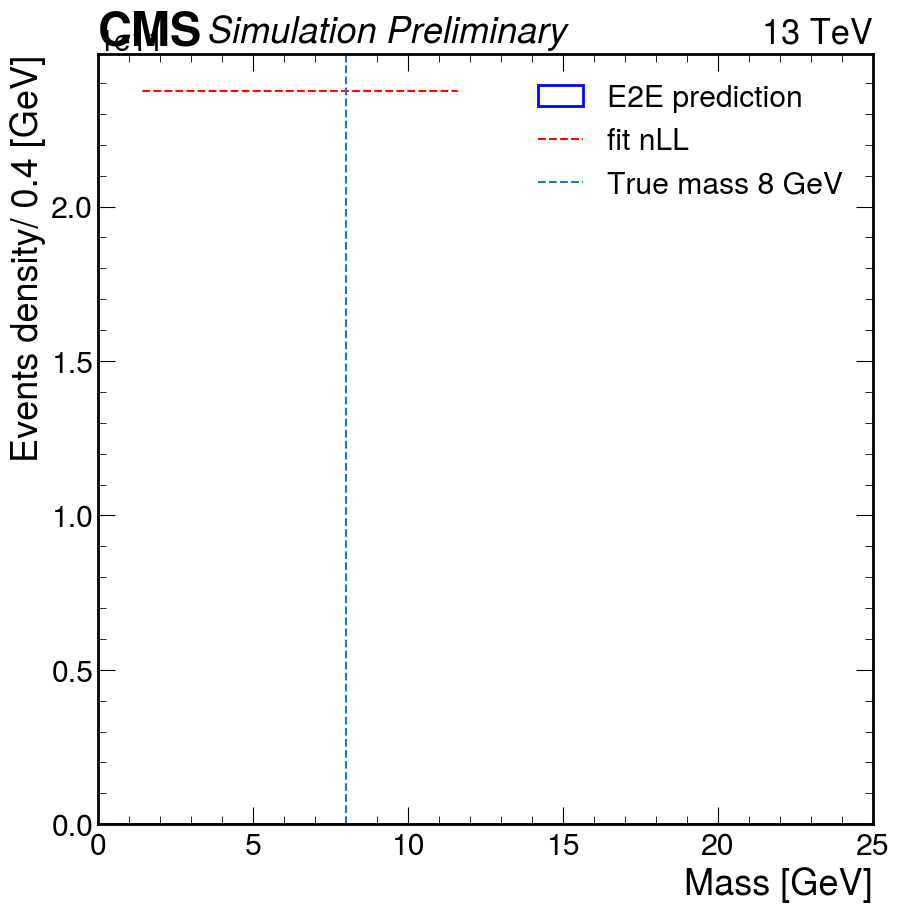

for mass:   10
FITTED PARAMETER [9236249.48993225   15282.01980787 2669145.82108969]


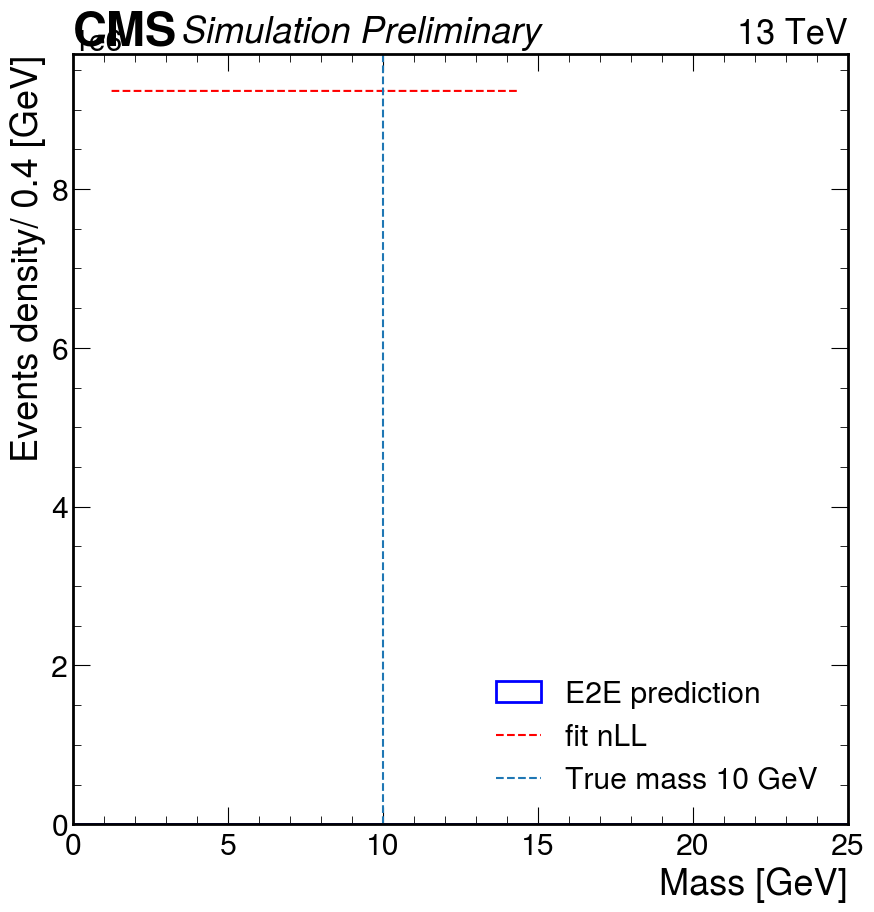

for mass:   12
FITTED PARAMETER [20654918.59678115 -2354207.07517592  7131573.99144857]


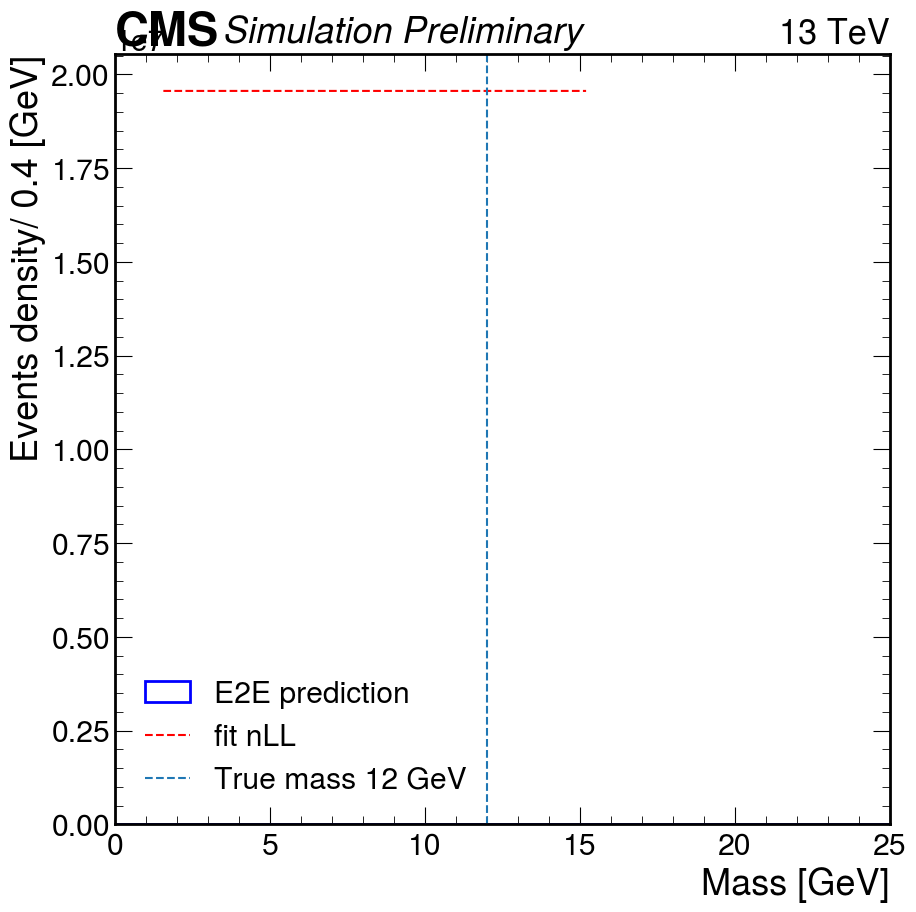

for mass:   14
FITTED PARAMETER [12242031.35316215   -65257.85650503  2629299.1096316 ]


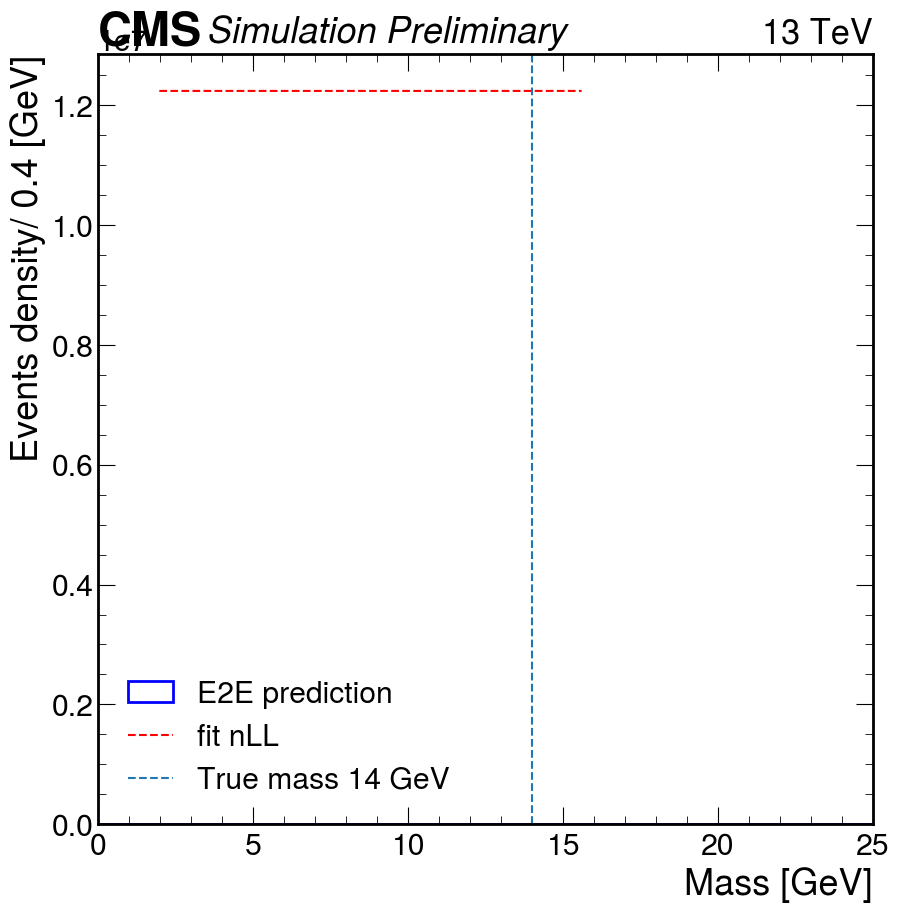

In [163]:
Masses  = ['3p7', '4', '5', '6', '8', '10', '12', '14']
for Mass in Masses:
    fit_signal(Mass)
    